# Unsupervised Learning

## Week 5: PCA, K-Means, and DBSCAN

## Learning Objectives

By the end of this notebook, you will be able to:

1. **Understand** the difference between supervised and unsupervised learning
2. **Apply** Principal Component Analysis (PCA) for dimensionality reduction
3. **Implement** K-Means clustering and interpret its results
4. **Use** DBSCAN for density-based clustering
5. **Compare** different clustering algorithms and choose the appropriate one
6. **Evaluate** clustering quality using various metrics

## 1. Introduction to Unsupervised Learning

**Unsupervised learning** is a type of machine learning where we work with **unlabeled data**. Unlike supervised learning, there are no target variables to predict. Instead, we aim to discover hidden patterns, structures, or relationships in the data.

### Two Main Categories:

| Category | Goal | Examples |
|----------|------|----------|
| **Clustering** | Group similar data points together | K-Means, DBSCAN, Hierarchical |
| **Dimensionality Reduction** | Reduce the number of features while preserving important information | PCA, t-SNE, UMAP |

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.datasets import make_blobs, make_moons

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

---

## 2. Principal Component Analysis (PCA)

### 2.1 What is PCA?

**PCA** is a dimensionality reduction technique that transforms data into a new coordinate system where:
- The first axis (PC1) captures the **maximum variance**
- Each subsequent axis captures the maximum remaining variance
- All axes are **orthogonal** (perpendicular) to each other

### 2.2 Mathematical Foundation

#### Step 1: Center the Data
Subtract the mean from each feature:
$$\bar{X} = X - \mu$$

where $\mu = \frac{1}{n}\sum_{i=1}^{n} x_i$

#### Step 2: Compute Covariance Matrix
$$C = \frac{1}{n-1}\bar{X}^T\bar{X}$$

#### Step 3: Eigenvalue Decomposition
Find eigenvalues $\lambda$ and eigenvectors $v$ such that:
$$Cv = \lambda v$$

#### Step 4: Project Data
Transform data using the top $k$ eigenvectors:
$$Z = \bar{X}W_k$$

where $W_k$ contains the top $k$ eigenvectors as columns.

#### Explained Variance Ratio
$$\text{Explained Variance Ratio}_i = \frac{\lambda_i}{\sum_{j=1}^{p}\lambda_j}$$

In [2]:
# Generate sample data with multiple features
from sklearn.datasets import load_iris

# Load iris dataset (4 features)
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

print(f"Original shape: {X_iris.shape}")
print(f"Features: {iris.feature_names}")

Original shape: (150, 4)
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [3]:
# Step 1: Standardize the data (important for PCA!)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_iris)

# Step 2: Apply PCA
pca = PCA(n_components=4)  # Keep all components first
X_pca = pca.fit_transform(X_scaled)

# Step 3: Analyze explained variance
print("Explained Variance Ratio per component:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"  PC{i+1}: {var:.4f} ({var*100:.2f}%)")

print(f"\nCumulative explained variance:")
cumsum = np.cumsum(pca.explained_variance_ratio_)
for i, c in enumerate(cumsum):
    print(f"  PC1-{i+1}: {c:.4f} ({c*100:.2f}%)")

Explained Variance Ratio per component:
  PC1: 0.7296 (72.96%)
  PC2: 0.2285 (22.85%)
  PC3: 0.0367 (3.67%)
  PC4: 0.0052 (0.52%)

Cumulative explained variance:
  PC1-1: 0.7296 (72.96%)
  PC1-2: 0.9581 (95.81%)
  PC1-3: 0.9948 (99.48%)
  PC1-4: 1.0000 (100.00%)


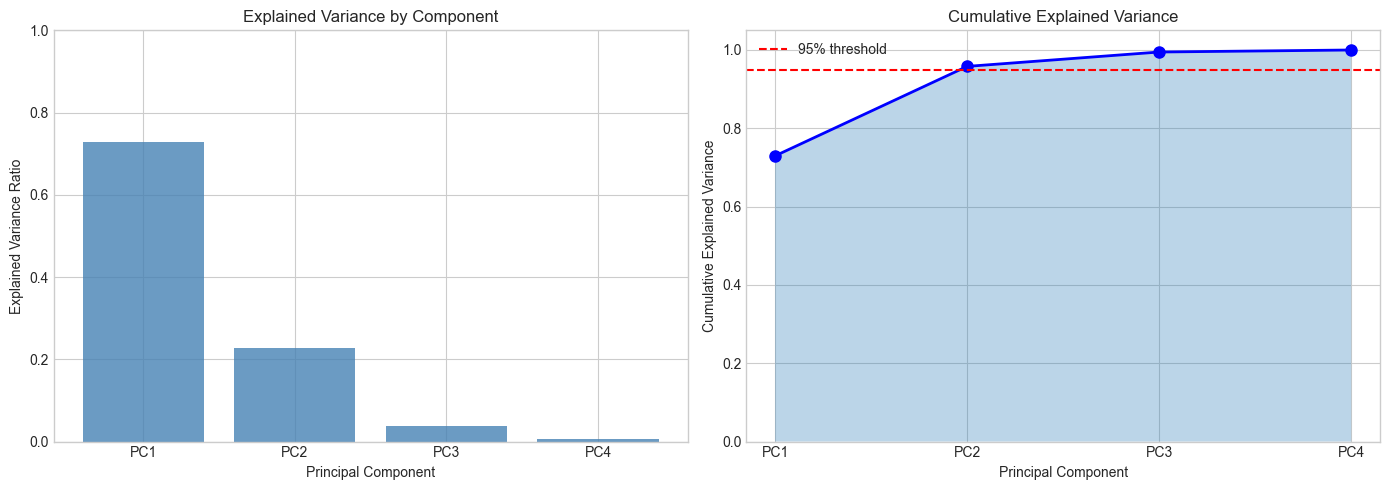

In [4]:
# Visualize explained variance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot of individual explained variance
ax1 = axes[0]
components = [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))]
ax1.bar(components, pca.explained_variance_ratio_, color='steelblue', alpha=0.8)
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Explained Variance by Component')
ax1.set_ylim(0, 1)

# Cumulative explained variance
ax2 = axes[1]
ax2.plot(components, cumsum, 'bo-', linewidth=2, markersize=8)
ax2.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
ax2.fill_between(components, cumsum, alpha=0.3)
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.set_title('Cumulative Explained Variance')
ax2.set_ylim(0, 1.05)
ax2.legend()

plt.tight_layout()
plt.show()

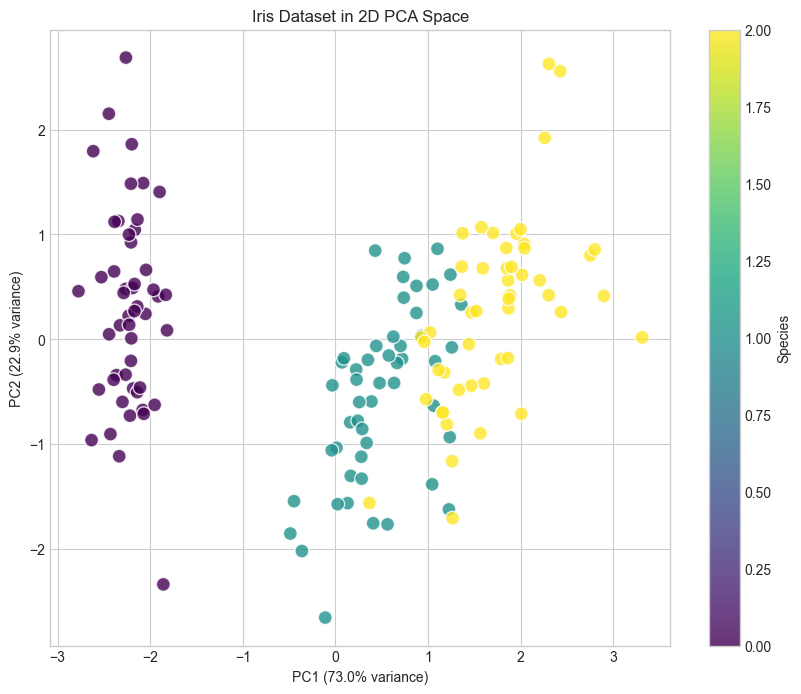

Total variance explained by 2 components: 95.81%


In [5]:
# Visualize data in 2D PCA space
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                      c=y_iris, cmap='viridis', 
                      edgecolors='white', s=100, alpha=0.8)
plt.colorbar(scatter, label='Species')
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.title('Iris Dataset in 2D PCA Space')
plt.show()

print(f"Total variance explained by 2 components: {sum(pca_2d.explained_variance_ratio_)*100:.2f}%")

---

## 3. K-Means Clustering

### 3.1 What is K-Means?

**K-Means** is a partitioning algorithm that divides data into $k$ non-overlapping clusters. Each data point belongs to the cluster with the nearest centroid.

### 3.2 Mathematical Foundation

#### Objective Function (Inertia)
K-Means minimizes the **Within-Cluster Sum of Squares (WCSS)**:

$$J = \sum_{i=1}^{n}\sum_{j=1}^{k} r_{ij} \|x_i - \mu_j\|^2$$

where:
- $r_{ij} = 1$ if point $x_i$ belongs to cluster $j$, otherwise $0$
- $\mu_j$ is the centroid of cluster $j$
- $\|x_i - \mu_j\|^2$ is the squared Euclidean distance

#### Centroid Update
$$\mu_j = \frac{\sum_{i=1}^{n} r_{ij} x_i}{\sum_{i=1}^{n} r_{ij}}$$

### 3.3 Algorithm Steps

1. **Initialize**: Randomly select $k$ initial centroids
2. **Assign**: Assign each point to the nearest centroid
3. **Update**: Recalculate centroids as mean of assigned points
4. **Repeat**: Steps 2-3 until convergence (centroids don't change)

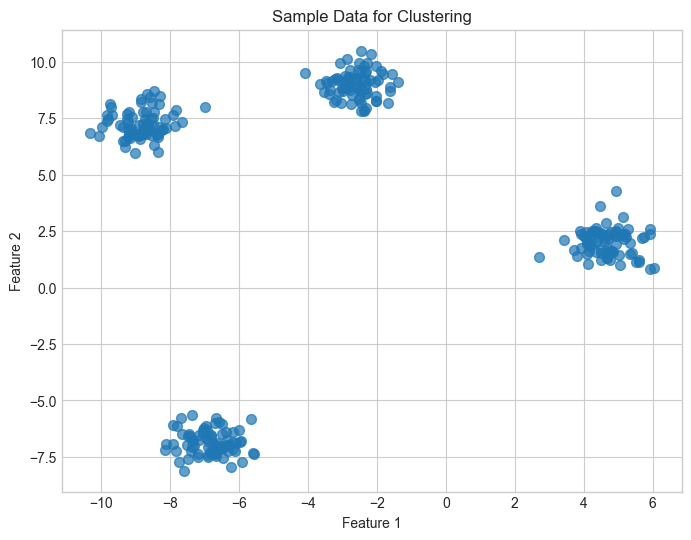

In [6]:
# Generate data with clear cluster structure
X_blobs, y_blobs = make_blobs(n_samples=300, centers=4, 
                              cluster_std=0.60, random_state=42)

# Visualize the data
plt.figure(figsize=(8, 6))
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], s=50, alpha=0.7)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Sample Data for Clustering')
plt.show()

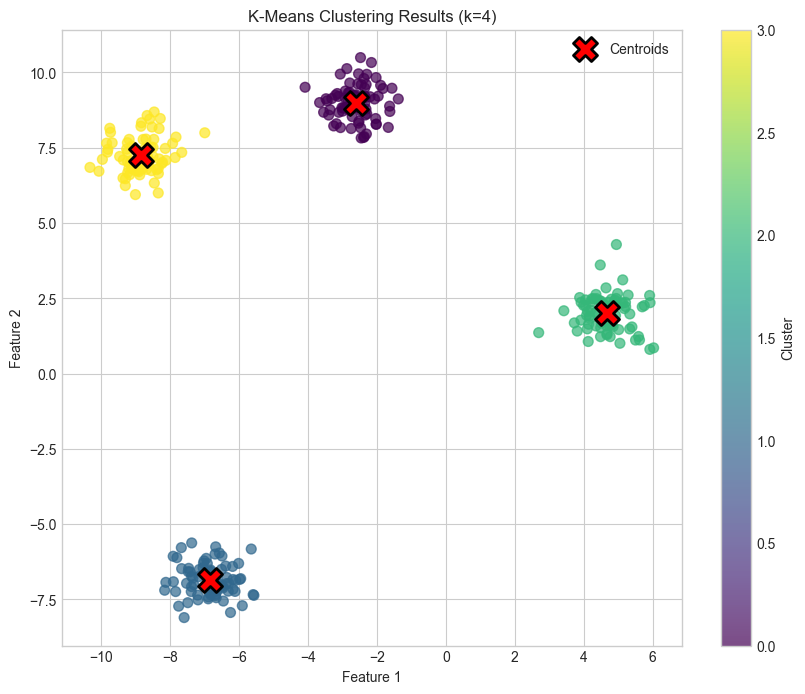

Inertia (WCSS): 203.89
Number of iterations: 2


In [7]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_blobs)

# Get cluster centers
centers = kmeans.cluster_centers_

# Visualize results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c=cluster_labels, 
                      cmap='viridis', s=50, alpha=0.7)
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', 
            s=300, edgecolors='black', linewidths=2, label='Centroids')
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-Means Clustering Results (k=4)')
plt.legend()
plt.show()

print(f"Inertia (WCSS): {kmeans.inertia_:.2f}")
print(f"Number of iterations: {kmeans.n_iter_}")

### 3.4 Choosing the Optimal k: Elbow Method

The **Elbow Method** helps determine the optimal number of clusters by plotting inertia vs. k and looking for the "elbow" point where the rate of decrease sharply changes.

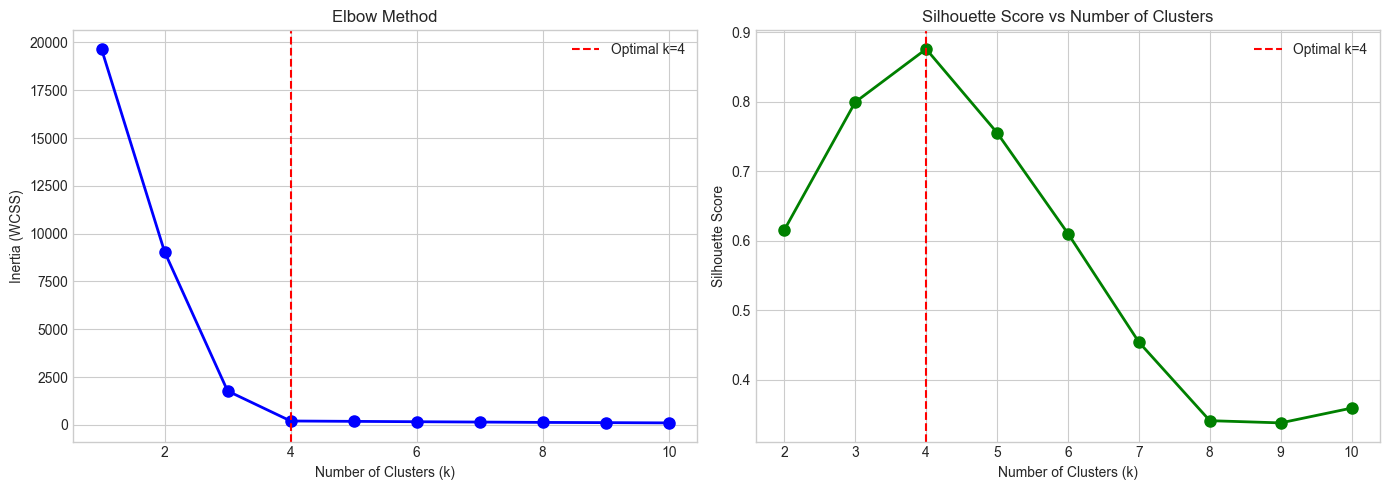

In [8]:
# Calculate inertia for different values of k
k_range = range(1, 11)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X_blobs)
    inertias.append(kmeans_temp.inertia_)
    if k > 1:  # Silhouette score requires at least 2 clusters
        silhouette_scores.append(silhouette_score(X_blobs, kmeans_temp.labels_))

# Plot elbow curve and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot
ax1 = axes[0]
ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia (WCSS)')
ax1.set_title('Elbow Method')
ax1.axvline(x=4, color='r', linestyle='--', label='Optimal k=4')
ax1.legend()

# Silhouette score plot
ax2 = axes[1]
ax2.plot(range(2, 11), silhouette_scores, 'go-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score vs Number of Clusters')
ax2.axvline(x=4, color='r', linestyle='--', label='Optimal k=4')
ax2.legend()

plt.tight_layout()
plt.show()

---

## 4. DBSCAN (Density-Based Spatial Clustering)

### 4.1 What is DBSCAN?

**DBSCAN** groups together points that are closely packed together, marking points in low-density regions as outliers. Unlike K-Means, it:
- Does **not** require specifying the number of clusters
- Can find **arbitrarily shaped** clusters
- Is robust to **outliers**

### 4.2 Key Concepts

| Term | Definition |
|------|------------|
| **ε (eps)** | Maximum distance between two points to be considered neighbors |
| **MinPts** | Minimum number of points required to form a dense region |
| **Core Point** | A point with at least MinPts neighbors within ε distance |
| **Border Point** | A point within ε of a core point but with fewer than MinPts neighbors |
| **Noise Point** | A point that is neither core nor border (outlier) |

### 4.3 Mathematical Definition

#### ε-neighborhood
$$N_\varepsilon(x) = \{y \in D : d(x, y) \leq \varepsilon\}$$

#### Core Point Condition
$$|N_\varepsilon(x)| \geq \text{MinPts}$$

#### Density-Reachability
A point $p$ is **directly density-reachable** from $q$ if:
1. $p \in N_\varepsilon(q)$
2. $q$ is a core point

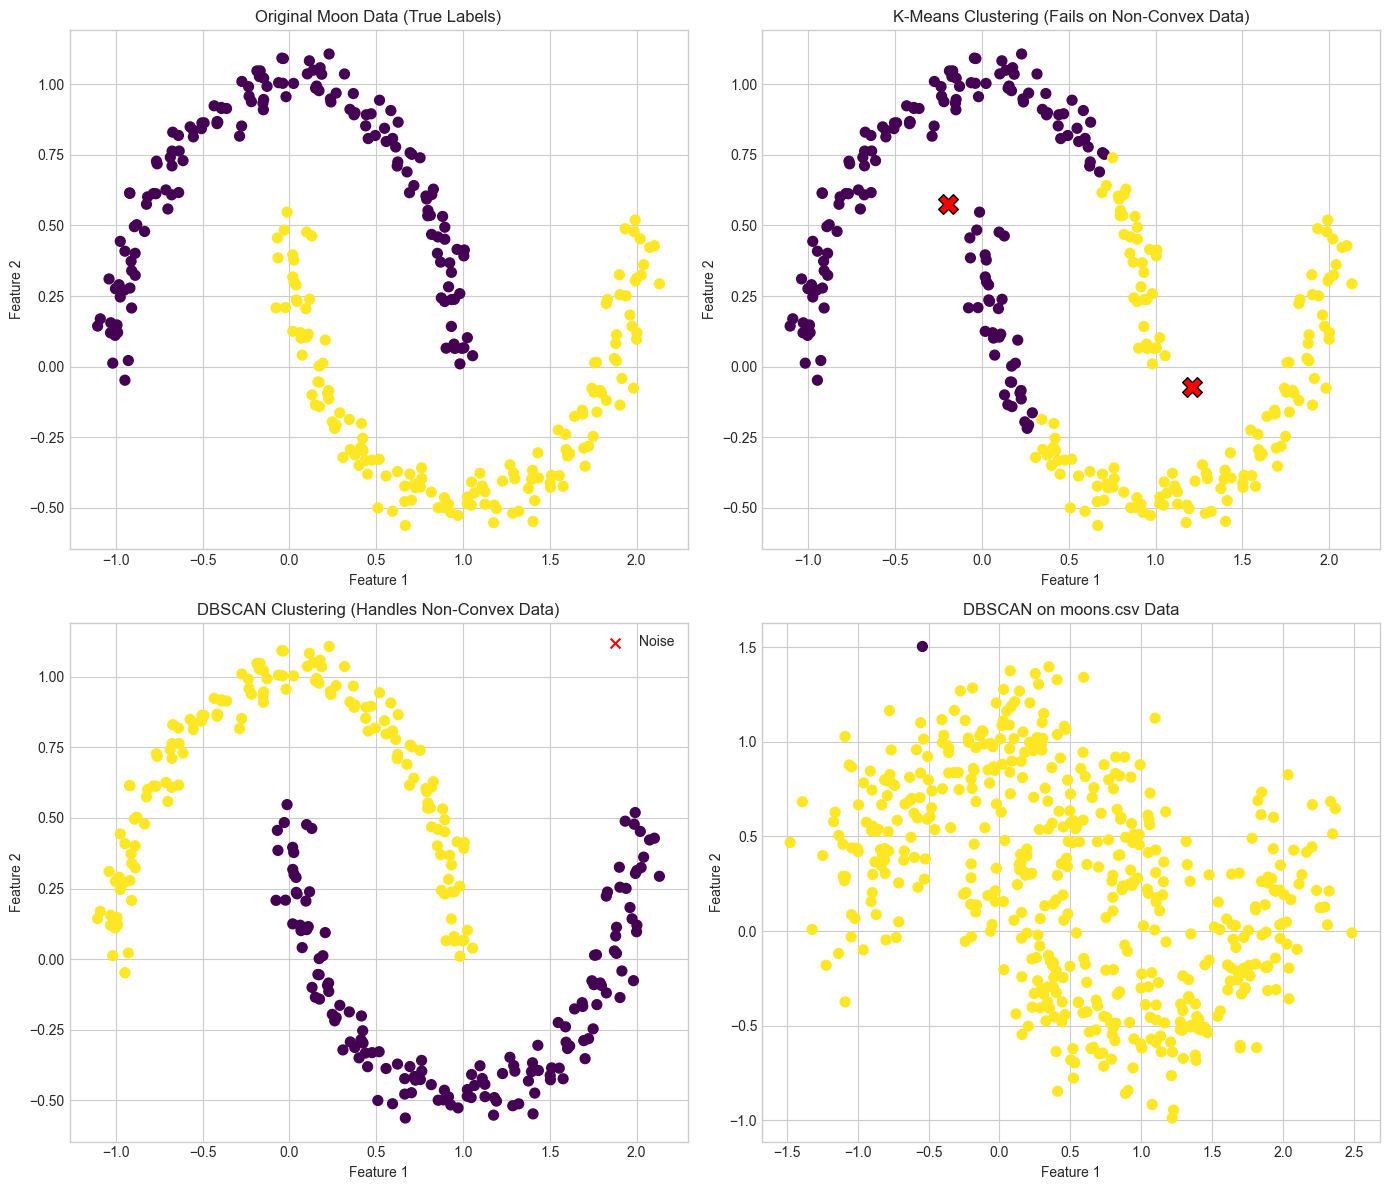

DBSCAN found 2 clusters
Number of noise points: 0


In [9]:
# Generate moon-shaped data (non-convex clusters)
X_moons, y_moons = make_moons(n_samples=300, noise=0.05, random_state=42)

# Load the moons.csv data
X_csv = pd.read_csv('../data/moons.csv')
y_csv = X_csv.pop('Label')

# Compare K-Means vs DBSCAN on moon-shaped data
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Original data
ax1 = axes[0, 0]
ax1.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap='viridis', s=50)
ax1.set_title('Original Moon Data (True Labels)')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')

# K-Means on moon data
kmeans_moons = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans_labels = kmeans_moons.fit_predict(X_moons)

ax2 = axes[0, 1]
ax2.scatter(X_moons[:, 0], X_moons[:, 1], c=kmeans_labels, cmap='viridis', s=50)
ax2.scatter(kmeans_moons.cluster_centers_[:, 0], kmeans_moons.cluster_centers_[:, 1], 
            c='red', marker='X', s=200, edgecolors='black')
ax2.set_title('K-Means Clustering (Fails on Non-Convex Data)')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')

# DBSCAN on moon data
dbscan_moons = DBSCAN(eps=0.2, min_samples=5)
dbscan_labels = dbscan_moons.fit_predict(X_moons)

ax3 = axes[1, 0]
# Handle noise points (-1 label)
colors = dbscan_labels.copy().astype(float)
colors[dbscan_labels == -1] = np.nan  # Noise points
scatter = ax3.scatter(X_moons[:, 0], X_moons[:, 1], c=colors, cmap='viridis', s=50)
ax3.scatter(X_moons[dbscan_labels == -1, 0], X_moons[dbscan_labels == -1, 1], 
            c='red', marker='x', s=50, label='Noise')
ax3.set_title('DBSCAN Clustering (Handles Non-Convex Data)')
ax3.set_xlabel('Feature 1')
ax3.set_ylabel('Feature 2')
ax3.legend()

# DBSCAN on CSV data
dbscan_csv = DBSCAN(eps=0.3, min_samples=5)
dbscan_csv_labels = dbscan_csv.fit_predict(X_csv)

ax4 = axes[1, 1]
ax4.scatter(X_csv['Feature1'], X_csv['Feature2'], c=dbscan_csv_labels, cmap='viridis', s=50)
ax4.set_title('DBSCAN on moons.csv Data')
ax4.set_xlabel('Feature 1')
ax4.set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

print(f"DBSCAN found {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)} clusters")
print(f"Number of noise points: {sum(dbscan_labels == -1)}")

---

## 5. Algorithm Comparison

### 5.1 K-Means vs DBSCAN

| Aspect | K-Means | DBSCAN |
|--------|---------|--------|
| **Cluster Shape** | Spherical (convex) | Arbitrary |
| **Number of Clusters** | Must specify k | Automatically determined |
| **Outlier Handling** | No (assigns all points) | Yes (marks as noise) |
| **Scalability** | O(n×k×i) - Fast | O(n²) - Slower |
| **Parameters** | k (number of clusters) | eps, min_samples |
| **Sensitivity** | To initialization | To parameter choice |

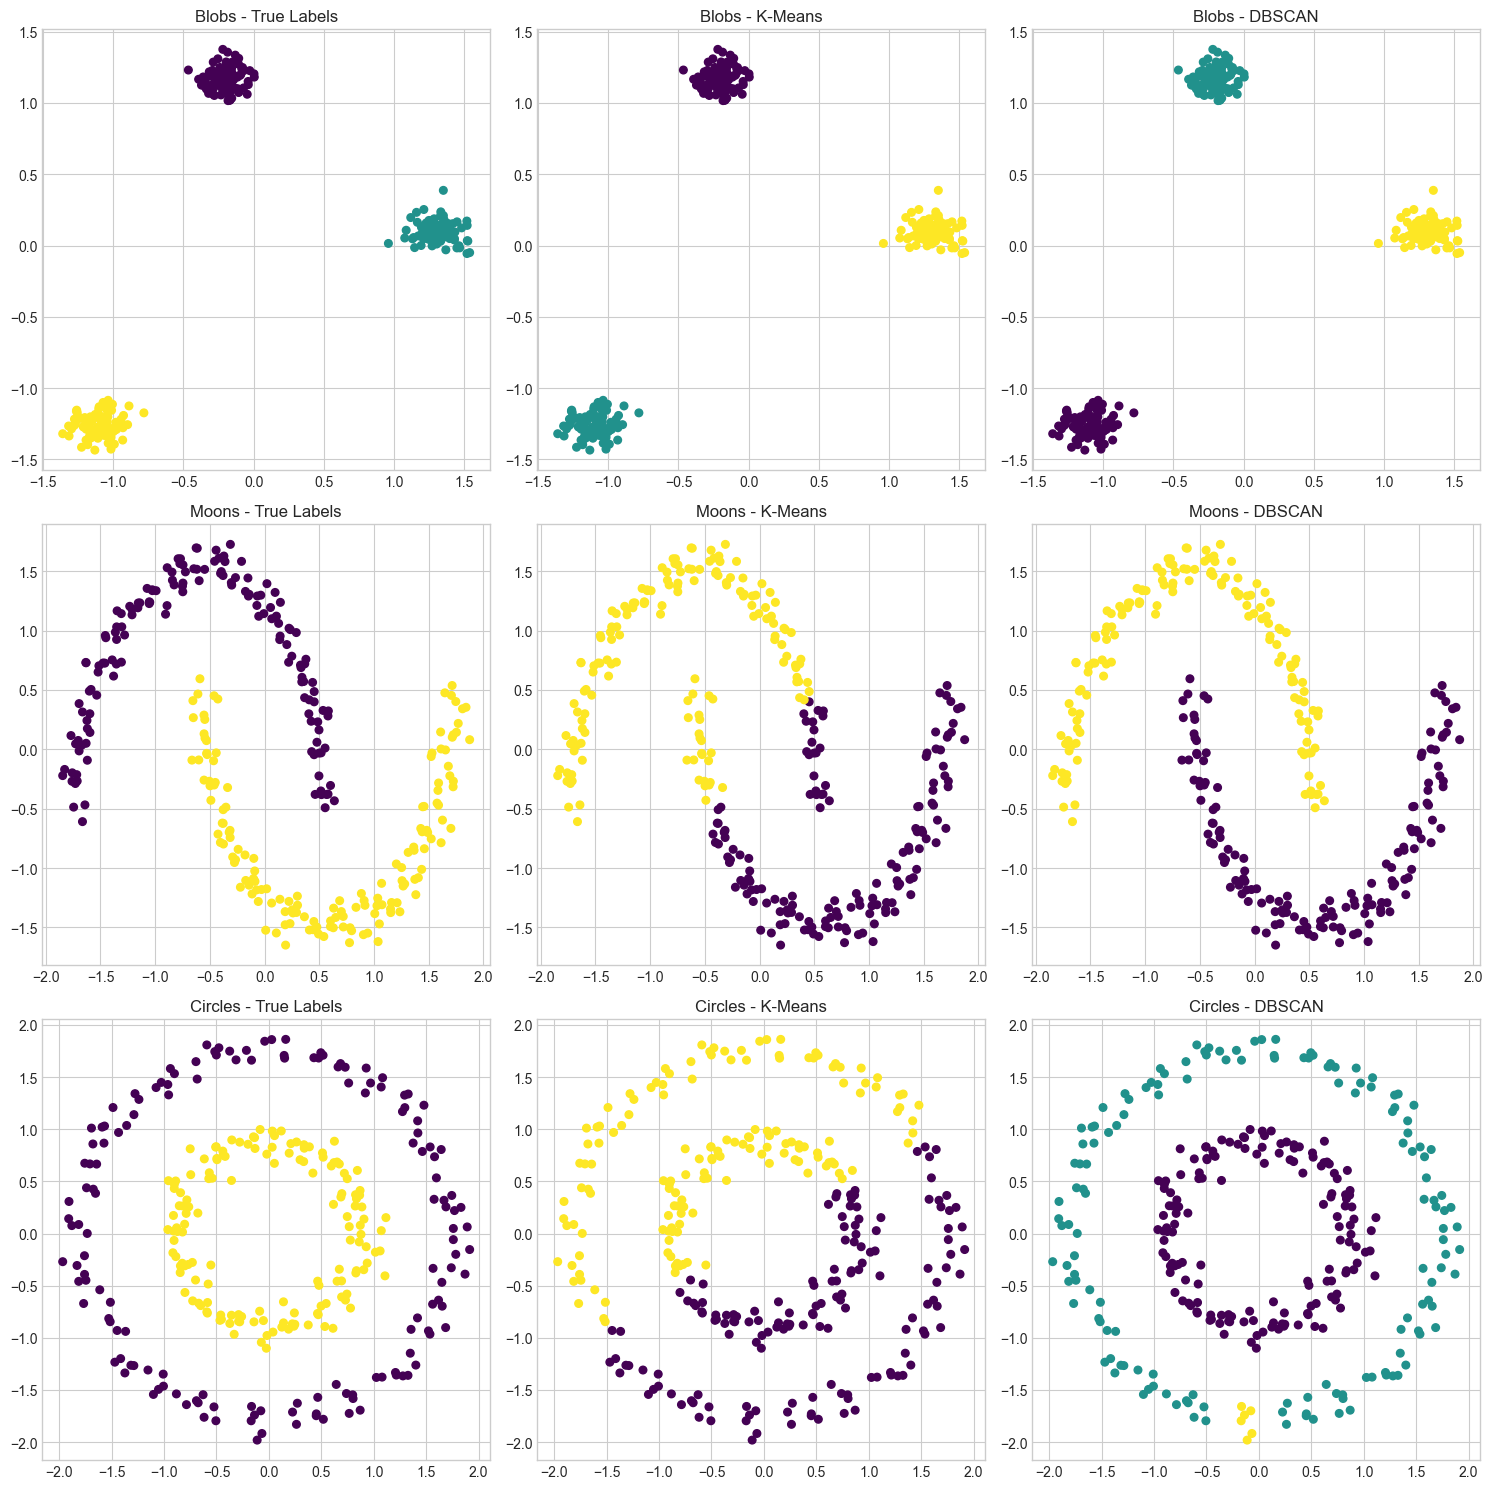

In [10]:
# Create various datasets to compare algorithms
from sklearn.datasets import make_circles

# Generate different data patterns
datasets = [
    ('Blobs', make_blobs(n_samples=300, centers=3, cluster_std=0.5, random_state=42)),
    ('Moons', make_moons(n_samples=300, noise=0.05, random_state=42)),
    ('Circles', make_circles(n_samples=300, noise=0.05, factor=0.5, random_state=42)),
]

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for row, (name, (X, y)) in enumerate(datasets):
    # Scale data
    X_scaled = StandardScaler().fit_transform(X)
    
    # Original
    axes[row, 0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='viridis', s=30)
    axes[row, 0].set_title(f'{name} - True Labels')
    
    # K-Means
    km_labels = KMeans(n_clusters=len(set(y)), random_state=42, n_init=10).fit_predict(X_scaled)
    axes[row, 1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=km_labels, cmap='viridis', s=30)
    axes[row, 1].set_title(f'{name} - K-Means')
    
    # DBSCAN
    db_labels = DBSCAN(eps=0.3, min_samples=5).fit_predict(X_scaled)
    axes[row, 2].scatter(X_scaled[:, 0], X_scaled[:, 1], c=db_labels, cmap='viridis', s=30)
    axes[row, 2].set_title(f'{name} - DBSCAN')

plt.tight_layout()
plt.show()

---

## 6. Clustering Evaluation Metrics

### 6.1 Internal Metrics (No Ground Truth Required)

#### Silhouette Score
Measures how similar a point is to its own cluster vs. other clusters:
$$s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}$$

where:
- $a(i)$ = mean distance to other points in same cluster
- $b(i)$ = mean distance to points in nearest different cluster
- Range: [-1, 1], higher is better

#### Calinski-Harabasz Index
$$CH = \frac{SS_B / (k-1)}{SS_W / (n-k)}$$

where $SS_B$ is between-cluster variance and $SS_W$ is within-cluster variance.
Higher values indicate better defined clusters.

#### Davies-Bouldin Index
$$DB = \frac{1}{k}\sum_{i=1}^{k} \max_{j \neq i} \frac{\sigma_i + \sigma_j}{d(c_i, c_j)}$$

Lower values indicate better clustering.

In [11]:
# Evaluate clustering on blobs data
X_eval, y_eval = make_blobs(n_samples=500, centers=4, cluster_std=0.8, random_state=42)
X_eval_scaled = StandardScaler().fit_transform(X_eval)

# Compare different k values
results = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_eval_scaled)
    
    sil = silhouette_score(X_eval_scaled, labels)
    ch = calinski_harabasz_score(X_eval_scaled, labels)
    db = davies_bouldin_score(X_eval_scaled, labels)
    
    results.append({
        'k': k,
        'Silhouette': sil,
        'Calinski-Harabasz': ch,
        'Davies-Bouldin': db,
        'Inertia': kmeans.inertia_
    })

results_df = pd.DataFrame(results)
print("Clustering Evaluation Metrics:")
print(results_df.to_string(index=False))

Clustering Evaluation Metrics:
 k  Silhouette  Calinski-Harabasz  Davies-Bouldin    Inertia
 2    0.572697         462.832668        0.553534 518.300446
 3    0.766651        2041.240774        0.345216 108.527569
 4    0.839294        8696.812821        0.224655  18.656128
 5    0.711742        7333.100853        0.556290  16.595477
 6    0.578126        6570.859598        0.812165  14.814294
 7    0.460138        6176.297650        0.983103  13.128886


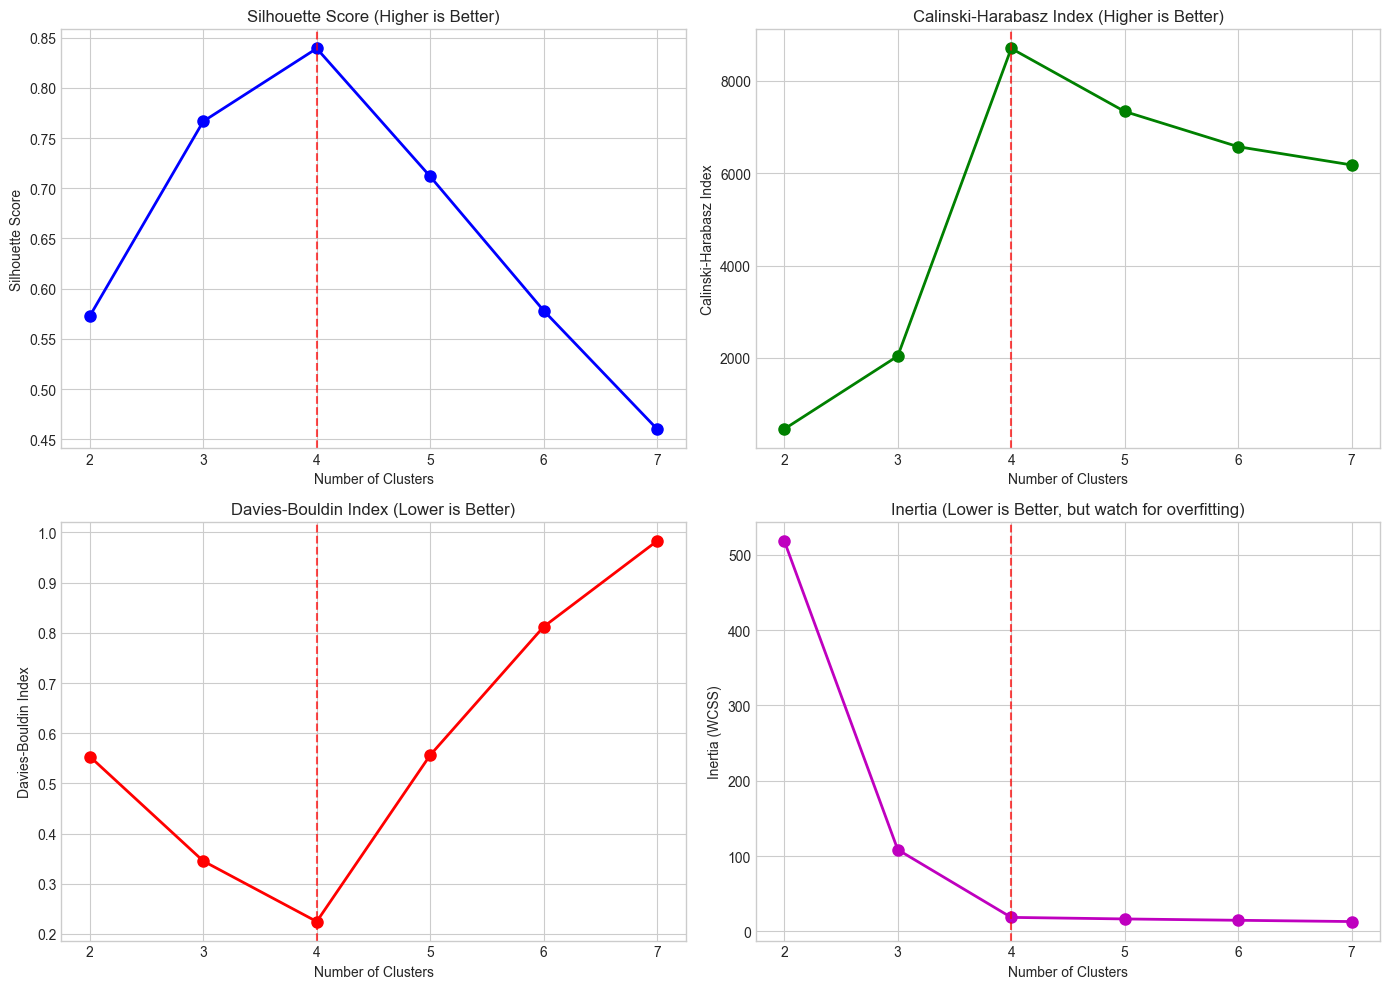

In [12]:
# Visualize metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Silhouette Score
axes[0, 0].plot(results_df['k'], results_df['Silhouette'], 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of Clusters')
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].set_title('Silhouette Score (Higher is Better)')
axes[0, 0].axvline(x=4, color='r', linestyle='--', alpha=0.7)

# Calinski-Harabasz Index
axes[0, 1].plot(results_df['k'], results_df['Calinski-Harabasz'], 'go-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Number of Clusters')
axes[0, 1].set_ylabel('Calinski-Harabasz Index')
axes[0, 1].set_title('Calinski-Harabasz Index (Higher is Better)')
axes[0, 1].axvline(x=4, color='r', linestyle='--', alpha=0.7)

# Davies-Bouldin Index
axes[1, 0].plot(results_df['k'], results_df['Davies-Bouldin'], 'ro-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Number of Clusters')
axes[1, 0].set_ylabel('Davies-Bouldin Index')
axes[1, 0].set_title('Davies-Bouldin Index (Lower is Better)')
axes[1, 0].axvline(x=4, color='r', linestyle='--', alpha=0.7)

# Inertia
axes[1, 1].plot(results_df['k'], results_df['Inertia'], 'mo-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Number of Clusters')
axes[1, 1].set_ylabel('Inertia (WCSS)')
axes[1, 1].set_title('Inertia (Lower is Better, but watch for overfitting)')
axes[1, 1].axvline(x=4, color='r', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

---

## 7. Summary

### Key Takeaways

1. **PCA** reduces dimensionality by projecting data onto principal components that capture maximum variance
2. **K-Means** is fast and works well for spherical clusters, but requires specifying k
3. **DBSCAN** can find arbitrary shaped clusters and handles outliers, but is sensitive to parameters
4. **Always scale your data** before applying these algorithms
5. Use **multiple metrics** to evaluate clustering quality

### When to Use Each Algorithm

| Situation | Recommended Algorithm |
|-----------|----------------------|
| High-dimensional data | Start with PCA |
| Known number of clusters | K-Means |
| Unknown number of clusters | DBSCAN |
| Non-convex clusters | DBSCAN |
| Large datasets | K-Means (faster) |
| Outlier detection | DBSCAN |

---

## 8. Exercises

### Exercise 1: PCA on House Prices Data
Load the `house_prices.csv` data, apply PCA, and determine how many components are needed to explain 95% of the variance.

### Exercise 2: Optimal K Selection
Generate your own blob data with 5 centers and use the elbow method to find the optimal k. Verify with silhouette score.

### Exercise 3: DBSCAN Parameter Tuning
Experiment with different `eps` and `min_samples` values on the moons dataset. What happens when eps is too small? Too large?

### Exercise 4: Algorithm Comparison
Create a dataset with overlapping clusters. Compare K-Means and DBSCAN results. Which performs better?

### Exercise 5: Real-World Application
Use PCA to reduce the iris dataset to 2D, then apply both K-Means and DBSCAN. Compare results with actual species labels.

### Exercise 6: Visualization Challenge
Create a 3D visualization of the first 3 principal components of the iris dataset, colored by cluster assignments.

### Exercise 7: Metrics Interpretation
For a given clustering result, calculate and interpret all three internal metrics (Silhouette, Calinski-Harabasz, Davies-Bouldin).

---

## 9. Further Reading

- [scikit-learn Clustering Documentation](https://scikit-learn.org/stable/modules/clustering.html)
- [scikit-learn PCA Documentation](https://scikit-learn.org/stable/modules/decomposition.html#pca)
- [Cluster Analysis Wikipedia](https://en.wikipedia.org/wiki/Cluster_analysis)
- [DBSCAN Original Paper](https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf)
- [Silhouette Analysis](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)